# 순환 신경망으로 IMDB 리뷰 분류하기

IMDB 리뷰 데이터셋을 사용   
총 50,000개의 샘플 중 훈련 데이터와 테스트 데이터에 각 25,000개씩 나누어져 있다.   

두 가지 데이터셋 변형 방법   
1. 원-핫 인코딩   
2. 단어 임베딩   

참고) 자연어 처리에는 음성 인식, 기계 번역, 감성 분석 등이 있다.   
훈련 데이터셋을 종종 말뭉치(corpus)라고 한다.

텍스트 데이터의 단어마다 고유한 정수를 부여하여 숫자 데이터로 바꿀 수 있다.   
일반적으로 영어 문장은 모두 소문자로 바꾸고 구둣점을 삭제한 다음 공백을 기준으로 분리한다.   
이렇게 분리된 단어를 **토큰(token)**이라고 부른다.   
1개의 토큰이 하나의 타임스텝에 해당.

토큰에 예약된 정수: 0 패딩 / 1 문장의 시작 / 2 어휘 사전에 없는 토큰

텐서플로 IMDB 리뷰 데이터셋은 이미 정수로 바꾼 데이터가 있다.   
전체 데이터셋에서 가장 자주 등장하는 단어 500개만 사용(num_words=500).

In [25]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다. 
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

## IMDB 리뷰 데이터셋

In [26]:
from tensorflow.keras.datasets import imdb

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)

In [27]:
# 훈련 세트와 테스트 세트의 크기 확인
print(train_input.shape, test_input.shape)

(25000,) (25000,)


배열이 1차원으로 이루어져있다. 리뷰 텍스트는 길이가 제각각이므로, 고정 크기의 2차원배열보다 리뷰마다 '파이썬 리스트'로 담아야 메모리를 효율적으로 사용할 수 있다.   
참고) 가장 바깥 꺾쇠[]의 타입은 넘파이 배열

In [28]:
# 첫번째 리뷰의 길이: 218개의 '토큰'
print(len(train_input[0]))

218


In [29]:
# 두번째 리뷰: 189개의 '토큰'
print(len(train_input[1]))

189


In [30]:
# 기본 제목 텍스트
# 첫번째 리뷰의 정수 리스트
# 어휘 사전에 500개의 단어만 들어가있고, 어휘 사전에 없는 단어는 2로 표시됨
print(train_input[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [31]:
# 리뷰 별 타깃값 0 = 부정 / 1 = 긍정
print(train_target[:20])

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


In [32]:
# 검증 세트 떼어놓기: 20% (test_size=0.2)
from sklearn.model_selection import train_test_split

train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

In [33]:
# train_input에 있는 20000개 리뷰 각각의 길이 확인 / len(lengths) = 20000
import numpy as np

lengths = np.array([len(x) for x in train_input])

In [34]:
# 평균과 중간값 확인: 평균과 중간값의 차이가 큼 - 한쪽에 치우친 분포가 될 것같다.
print(np.mean(lengths), np.median(lengths))

239.00925 178.0


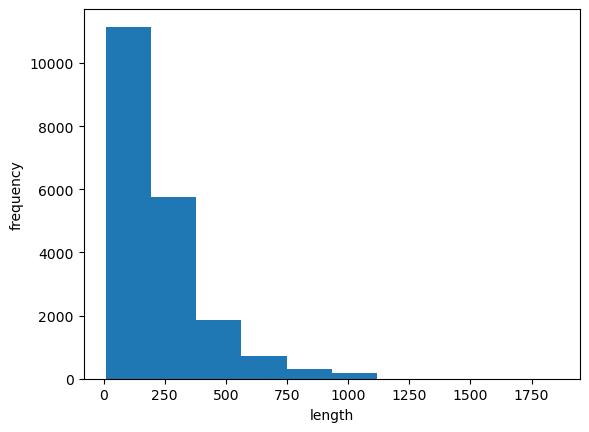

In [35]:
# 시각화해서 분포를 확인해보자. **필수** 치우친 데이터인지 확인해봐야 한다.

import matplotlib.pyplot as plt

plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

대부분의 리뷰 길이는 300 미만. 1000개의 단어가 넘는 리뷰때문에 평균이 높았다.   
100개의 단어를 기준으로 하자.   
- 100보다 작은 리뷰는 길이를 100에 맞추기 위해 패딩이 필요하다.
- 패딩 토큰 0을 추가.

In [36]:
# 패딩 함수: pad_sequences()
# maxlen에 원하는 길이를 지정하면 긴 경우는 잘라내고 짧은 경우는 0으로 패딩한다.
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100)

In [37]:
print(train_seq.shape)  # 2차원 배열로 변환되었다.
# 토큰의 갯수를 일제히 100으로 맞춰주었고, 즉 타임스텝이 100이다.

(20000, 100)


In [38]:
print(train_seq[0]) # 길이 조정 결과의 첫번째 샘플

[ 10   4  20   9   2 364 352   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10 451   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10 470 158]


In [39]:
# 길이 조정 전 첫번째 샘플과 비교
print(train_input[0][:10])  # 앞부분이 잘린 것을 알 수 있다.
print(train_input[0][-10:])

[1, 73, 89, 81, 25, 60, 2, 6, 20, 141]
[6, 2, 46, 7, 14, 20, 10, 10, 470, 158]


일반적으로 시퀀스의 뒷부분 정보가 더 유용할 것으로 기대되기 때문에 앞부분을 잘라낸다.   
시퀀스의 뒷부분을 잘라내고 싶다면 pad_sequences(truncating = 'post')   
(기본값은 'pre')

In [40]:
print(train_seq[5])

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2 352   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94 364 352   2   2  11 190
  24 484   2   7  94 205 405  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


앞부분에 0이 있는 것으로 보아, 이 샘플의 길이는 100보다 작았다.   
패딩 또한 앞부분에 추가된다.   
시퀀스의 마지막에 있는 단어가 셀의 은닉 상태에 가장 큰 영향을 미치게 되기 때문.   
기본값: pad_sequences(padding='pre')   
변경: 뒷부분 패딩 변경 = 'post'

In [41]:
# 검증 세트도 길이 맞춰주기
val_seq = pad_sequences(val_input, maxlen=100)

## 순환 신경망 만들기

여러 종류의 순환층 클래스가 있다.   
그 중 **SimpleRNN** 클래스가 가장 간단하다.   

우리의 목표는 **이진 분류(긍정/부정)**   
-> 마지막 출력층은 1개의 뉴런을 가지고 시그모이드 활성화 함수를 사용해야 한다.

In [42]:
# 먼저 Sequential() 클래스로 신경망 모델 생성해보자.
from tensorflow import keras

model = keras.Sequential()

model.add(keras.layers.SimpleRNN(8, input_shape=(100, 500), activation='tanh'))     # SimpleRNN 클래스 사용 (Dense / Conv2D 대신), 활성화 함수는 기본값 'tanh'
model.add(keras.layers.Dense(1, activation='sigmoid'))                              # 이진분류를 위해 sigmoid 활성화 함수 사용, 뉴런은 1

정수로 변환한 단어 데이터에서는 정수 사이에 어떤 관련도 없다.   
정숫값을 신경망에 입력하기 위해서는 관련성을 없앤 다른 방식을 찾아야 한다.   

**원-핫 인코딩**   
각 데이터마다 0과 1로 구성된 배열로 변환함.   
500개의 단어만 사용하도록 지정했기 때문에, 고유한 단어는 모두 500개.   
즉, 훈련 데이터에는 0 ~ 499까지의 정수가 잇다.   
원-핫 인코딩으로 표현하려면 배열의 길이가 500이어야 한다.

In [43]:
# 원-핫 인코딩으로 변환
train_oh = keras.utils.to_categorical(train_seq)

In [44]:
# 100개의 단어가 500만큼의 길이인 배열로 바뀐 것을 확인할 수 있다.
# SimpleRNN 클래스의 input_shape 매개변수의 값을 (100, 500)으로 지정한 이유이다.
print(train_oh.shape)

(20000, 100, 500)


In [45]:
print(train_oh[0][0][:12])  # 첫번째 샘플의 첫번째 토큰 '10'의 인코딩 결과

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [46]:
print(np.sum(train_oh[0][0]))   # 열한번째 원소 하나만 1이고 나머지는 전부 0

1.0


In [47]:
# 검증 세트 또한 원-핫 인코딩으로 변환
val_oh = keras.utils.to_categorical(val_seq)

In [48]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 8)                 4072      
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________


## 순환 신경망 훈련하기

In [49]:
# 학습률 변경을 위해 별도의 RMSprop 객체를 만들고 학습률 0.0001로 지정
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)

# 컴파일
model.compile(optimizer=rmsprop, loss='binary_crossentropy', 
              metrics=['accuracy'])

# Checkpoint 구성
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5', 
                                                save_best_only=True)

# EarlyStopping 구성
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

# 모델 훈련(에포크 100, 배치크기 64), history에 저장
history = model.fit(train_oh, train_target, epochs=100, batch_size=64,
                    validation_data=(val_oh, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 10s 27ms/step - loss: 0.6968 - accuracy: 0.5072 - val_loss: 0.6924 - val_accuracy: 0.5250
Epoch 2/100
313/313 [==============================] - 8s 26ms/step - loss: 0.6880 - accuracy: 0.5416 - val_loss: 0.6829 - val_accuracy: 0.5634
Epoch 3/100
313/313 [==============================] - 8s 25ms/step - loss: 0.6778 - accuracy: 0.5794 - val_loss: 0.6765 - val_accuracy: 0.5840
Epoch 4/100
313/313 [==============================] - 7s 23ms/step - loss: 0.6705 - accuracy: 0.5990 - val_loss: 0.6693 - val_accuracy: 0.6022
Epoch 5/100
313/313 [==============================] - 7s 23ms/step - loss: 0.6623 - accuracy: 0.6183 - val_loss: 0.6612 - val_accuracy: 0.6206
Epoch 6/100
313/313 [==============================] - 7s 24ms/step - loss: 0.6517 - accuracy: 0.6395 - val_loss: 0.6523 - val_accuracy: 0.6348
Epoch 7/100
313/313 [==============================] - 8s 25ms/step - loss: 0.6399 - accuracy: 0.6606 - val_loss: 0.6390 - val_accuracy

35번째 에포크에서 조기 종료됨.   
검증 세트에 대한 정확도는 약 80% 정도.

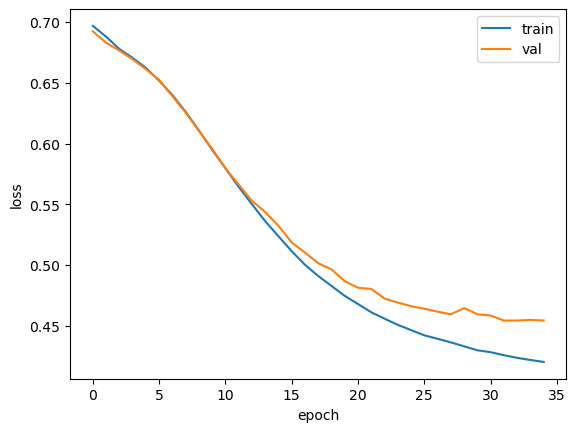

In [50]:
# 훈련 손실과 검증 손실을 그래프로 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 단어 임베딩을 사용하기

원-핫 인코딩의 단점: 입력 데이터가 매우 커진다. 토큰 1개를 500차원으로 늘렸기 때문에.   
**단어 임베딩**: 각 단어를 고정된 크기의 실수 벡터로 바꾸어준다.   
순환 신경망에서 텍스트를 처리할 때 즐겨 사용하는 방법.   
훨씬 의미 있는 값으로 채워지기 때문에 자연어 처리에서 더 좋은 성능을 내는 경우가 많다.   
keras.layers.Embedding 클래스로 임베딩 기능 사용 가능.   
모델에 임베딩 층을 추가하면, 훈련을 통해 데이터에서 좋은 단어 임베딩을 학습한다.   
단어 임베딩의 장점: 입력으로 정수 데이터를 그대로 받아서 사용한다. 메모리를 효율적으로 사용할 수 있다.

In [51]:
model2 = keras.Sequential()

# Embedding 클래스를 SimpleRNN 층 앞에 추가
model2.add(keras.layers.Embedding(500, 16, input_length=100))   # (어휘 사전 크기, 임베딩 벡터의 크기, 샘플의 길이)
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 8)                 200       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,209
Trainable params: 8,209
Non-trainable params: 0
_________________________________________________________________


원-핫 인코딩보다 훨씬 작은 크기의 벡터를 사용할 수 있다.   
500개의 각 토큰을 크기가 16인 벡터로 변경하기 때문에 총 500 * 16 = 8,000개의 모델 파라미터를 가진다.   
8개의 뉴런과 곱하기 위해 필요한 가중치 16 * 8 = 128개를 가진다.   
은닉 상태에 곱해지는 가중치 8 * 8 = 64개가 있다.   
8개의 절편까지 더하면, 전체 모델 파라미터의 개수는 128 + 64 + 8 = 200개

In [52]:
# 모델 훈련 과정
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', 
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 6s 17ms/step - loss: 0.6850 - accuracy: 0.5497 - val_loss: 0.6598 - val_accuracy: 0.6104
Epoch 2/100
313/313 [==============================] - 5s 17ms/step - loss: 0.6230 - accuracy: 0.6680 - val_loss: 0.6020 - val_accuracy: 0.6938
Epoch 3/100
313/313 [==============================] - 5s 16ms/step - loss: 0.5715 - accuracy: 0.7286 - val_loss: 0.5643 - val_accuracy: 0.7354
Epoch 4/100
313/313 [==============================] - 6s 18ms/step - loss: 0.5380 - accuracy: 0.7539 - val_loss: 0.5426 - val_accuracy: 0.7366
Epoch 5/100
313/313 [==============================] - 6s 18ms/step - loss: 0.5168 - accuracy: 0.7667 - val_loss: 0.5231 - val_accuracy: 0.7562
Epoch 6/100
313/313 [==============================] - 6s 19ms/step - loss: 0.5037 - accuracy: 0.7724 - val_loss: 0.5163 - val_accuracy: 0.7522
Epoch 7/100
313/313 [==============================] - 6s 19ms/step - loss: 0.4930 - accuracy: 0.7796 - val_loss: 0.5073 - val_accuracy:

에포크 23번째에서 중단?   
원-핫 인코딩을 사용한 모델과 비슷한 성능...이라고 한다.   
다만, 가중치 개수가 훨씬 작고, 훈련 세트 크기도 훨씬 줄어들어 이점이 있다.

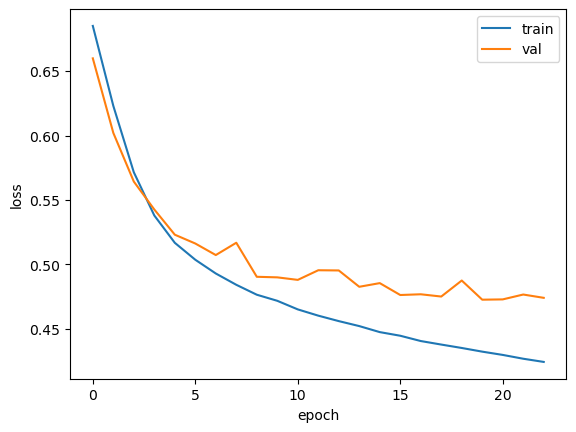

In [53]:
# 훈련 손실과 검증 손실 그래프 확인
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()